# Attack on Titan Character Network Analysis

The project examines from a network science standpoint the interactions among characters from the anime *Attack on Titan*. The work done has been structured as follows:

1. **Data Preparation**  
   Extracting and cleaning character data from a JSON files to a pandas dataset, including attributes like groups, roles, and episode appearances.

2. **Graph Construction**  
   Building an undirected tripartite graph connecting characters, episodes, and seasons, thus defining a triangular structure, with the basic shape
   character -- episode -- season which also implies a link character -- season.

3. **Exploratory Analysis**  
   Computing network properties, such as degree distribution and centrality measures, to identify key characters and interactions.

4. **Advanced Analysis**  
   Implementing community detection algorithms, testing power-law distributions, and modeling dynamic processes (e.g., SIR simulations) to reveal deeper network insights.

5. **Visualization**  
   Creating visualizations of the network and subgraphs, and exporting the results for better visualization in Gephi.



### 1) Data Preparation

Importing the necessessary libraries will be the obvious first step

In [50]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import scipy as sp
import seaborn as sns
import powerlaw
from node2vec import Node2Vec
import random
import matplotlib.pyplot as plt
import numpy as np
from cdlib import algorithms
import matplotlib.pyplot as plt
import statistics
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import metrics



The data is imported from a Json file and normalised into a pandas DataFrame. 
The data has been retrieved from: https://github.com/ZachMcM/attack-on-titan-api/blob/master/data/characters.json

In [6]:
# Assign the path to the JSON file
DATA_PATH = "/Users/michelecoaro/Documents/GitHub/AOT_Network/Data/characters.json"

# Loading the JSON data into a pandas DataFrame
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Normalize the JSON data into a DataFrame
df = pd.json_normalize(data) 
print("Original DataFrame shape:", df.shape)

# Display small sample to understand df structure
df.head(3)

Original DataFrame shape: (201, 16)


,id,name,img,alias,species,gender,age,height,relatives,birthplace,residence,status,occupation,groups,roles,episodes
0,1,Armin Arlelt,https://static.wikia.nocookie.net/shingekinoky...,[Colossal Titan],"[Human, Intelligent Titan]",Male,19,60 m (Colossal Titan form),"[{'family': 'Arlelt family', 'members': ['Unna...",Shiganshina District,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,https://static.wikia.nocookie.net/shingekinoky...,[],[Human],Female,19,unknown,"[{'family': 'Ackermann family', 'members': ['U...",Shiganshina District Outskirts? → Shiganshina ...,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,https://static.wikia.nocookie.net/shingekinoky...,[Horse face],[Human],Male,19,unknown,"[{'family': 'Kirschtein family', 'members': ['...",Trost District,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


Some attributes have been dropped to make the dataset leaner and more agile

In [7]:
columns_to_keep = [
    'id', 
    'name', 
    'alias', 
    'species', 
    'groups', 
    'roles', 
    'episodes'
]

df_cleaned = df[columns_to_keep].copy()

print("DataFrame shape after keeping necessary columns:", df_cleaned.shape)

df_cleaned.head(3)

DataFrame shape after keeping necessary columns: (201, 7)


,id,name,alias,species,groups,roles,episodes
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


Since the "episodes" column has a list of urls for episodes number, it is needed to extract the number of each individual episode.
This entails extracting "1" from "https://api.attackontitanapi.com/episodes/1". This allows for creation of a "seasons" column, which is based on the list of episodes the character appears in.
The result is a "seasons" column and a function that extracts the episode numbers from the list of urls in the "episodes" column.



In [8]:
def get_episode_number(url): #Given an episode URL, extract the number of the episode.
    return int(url.rstrip('/').split('/')[-1])

def determine_season(episode_num):
    if 1 <= episode_num <= 25:
        return 1
    elif 26 <= episode_num <= 37:
        return 2
    elif 38 <= episode_num <= 59:
        return 3
    elif 60 <= episode_num <= 94:
        return 4
    else:
        return None  # For safety, if anything is out of range

# Creating a new column that includes all seasons a character appears in,
# based on all the episodes that character is in.
def get_character_seasons(episodes):
    seasons = set()
    for ep_url in episodes:
        ep_num = get_episode_number(ep_url)
        s = determine_season(ep_num)
        if s:
            seasons.add(s)
    return sorted(list(seasons))

df_cleaned['seasons'] = df_cleaned['episodes'].apply(get_character_seasons)


# Display the updated DataFrame to the user
display(df_cleaned.head(5))
print("Number of characters:", df_cleaned.shape[0])
print("Columns now:", df_cleaned.columns.tolist())


,id,name,alias,species,groups,roles,episodes,seasons
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"


Number of characters: 201
Columns now: ['id', 'name', 'alias', 'species', 'groups', 'roles', 'episodes', 'seasons']


### Graph Construction

The objective is to create a graph with three node layers:

- Seasons (1, 2, 3, 4)
- Characters (by name)
- Episodes (by episode number)

The structure of an undirected tripartite graph will return the following edges:

- (season, character) if character appears in that season
- (character, episode) if character appears in that episode
- (season, episode) if the episode belongs to that season

In [9]:
# Creating graph object and adding nodes
G = nx.Graph()
seasons_list = [1, 2, 3, 4]
for s in seasons_list: #adding season nodes
    G.add_node(f"Season {s}", layer="season", season_number=s)

for idx, row in df_cleaned.iterrows(): #adding character nodes
    character_name = row['name'] 
    G.add_node(character_name, layer="character")

all_episode_numbers = set() #using set() to ensure uniqueness
for episodes_list in df_cleaned['episodes']:
    for e_url in episodes_list:
        ep_num = get_episode_number(e_url)
        all_episode_numbers.add(ep_num)

for ep in sorted(all_episode_numbers): #adding unique episode nodes
    G.add_node(f"Episode {ep}", layer="episode", episode_number=ep)

# Adding edges
for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    for s in row['seasons']:
        G.add_edge(f"Season {s}", character_name) #season - characters

for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    for e_url in row['episodes']:
        ep_num = get_episode_number(e_url)
        G.add_edge(character_name, f"Episode {ep_num}") #characters - episodes

for ep in all_episode_numbers:
    s = determine_season(ep)
    if s:
        G.add_edge(f"Season {s}", f"Episode {ep}") #season - episodes

print("Graph construction complete.") #if there are no errors, the graph has been constructed successfully

Graph construction complete.


Let's visualize the summary of the graph structure

In [10]:
# Constructing summary of the structure
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

# Display the first few nodes and edges
print("\nSample nodes:", list(G.nodes())[:10])
print("Sample edges:", list(G.edges())[:10])

Number of nodes in the graph: 292
Number of edges in the graph: 2695

Sample nodes: ['Season 1', 'Season 2', 'Season 3', 'Season 4', 'Armin Arlelt', 'Mikasa Ackermann', 'Jean Kirschtein', 'Conny Springer', 'Levi Ackermann', 'Buchwald']
Sample edges: [('Season 1', 'Armin Arlelt'), ('Season 1', 'Mikasa Ackermann'), ('Season 1', 'Jean Kirschtein'), ('Season 1', 'Conny Springer'), ('Season 1', 'Levi Ackermann'), ('Season 1', 'Buchwald'), ('Season 1', 'Hange Zoë'), ('Season 1', 'Sasha Braus'), ('Season 1', 'Lobov'), ('Season 1', 'Erwin Smith')]


Exporting the graph in .gml format for advanced visualization

In [11]:
output_gml_path = "big_graph.gml"
nx.write_gml(G, output_gml_path)
print(f"Graph successfully exported to {output_gml_path}")

Graph successfully exported to big_graph.gml


Let's visualize the result of the .gml file edited in Gephi. The dark nodes are seasons, the red ones are episodes and the pink/white are characters.

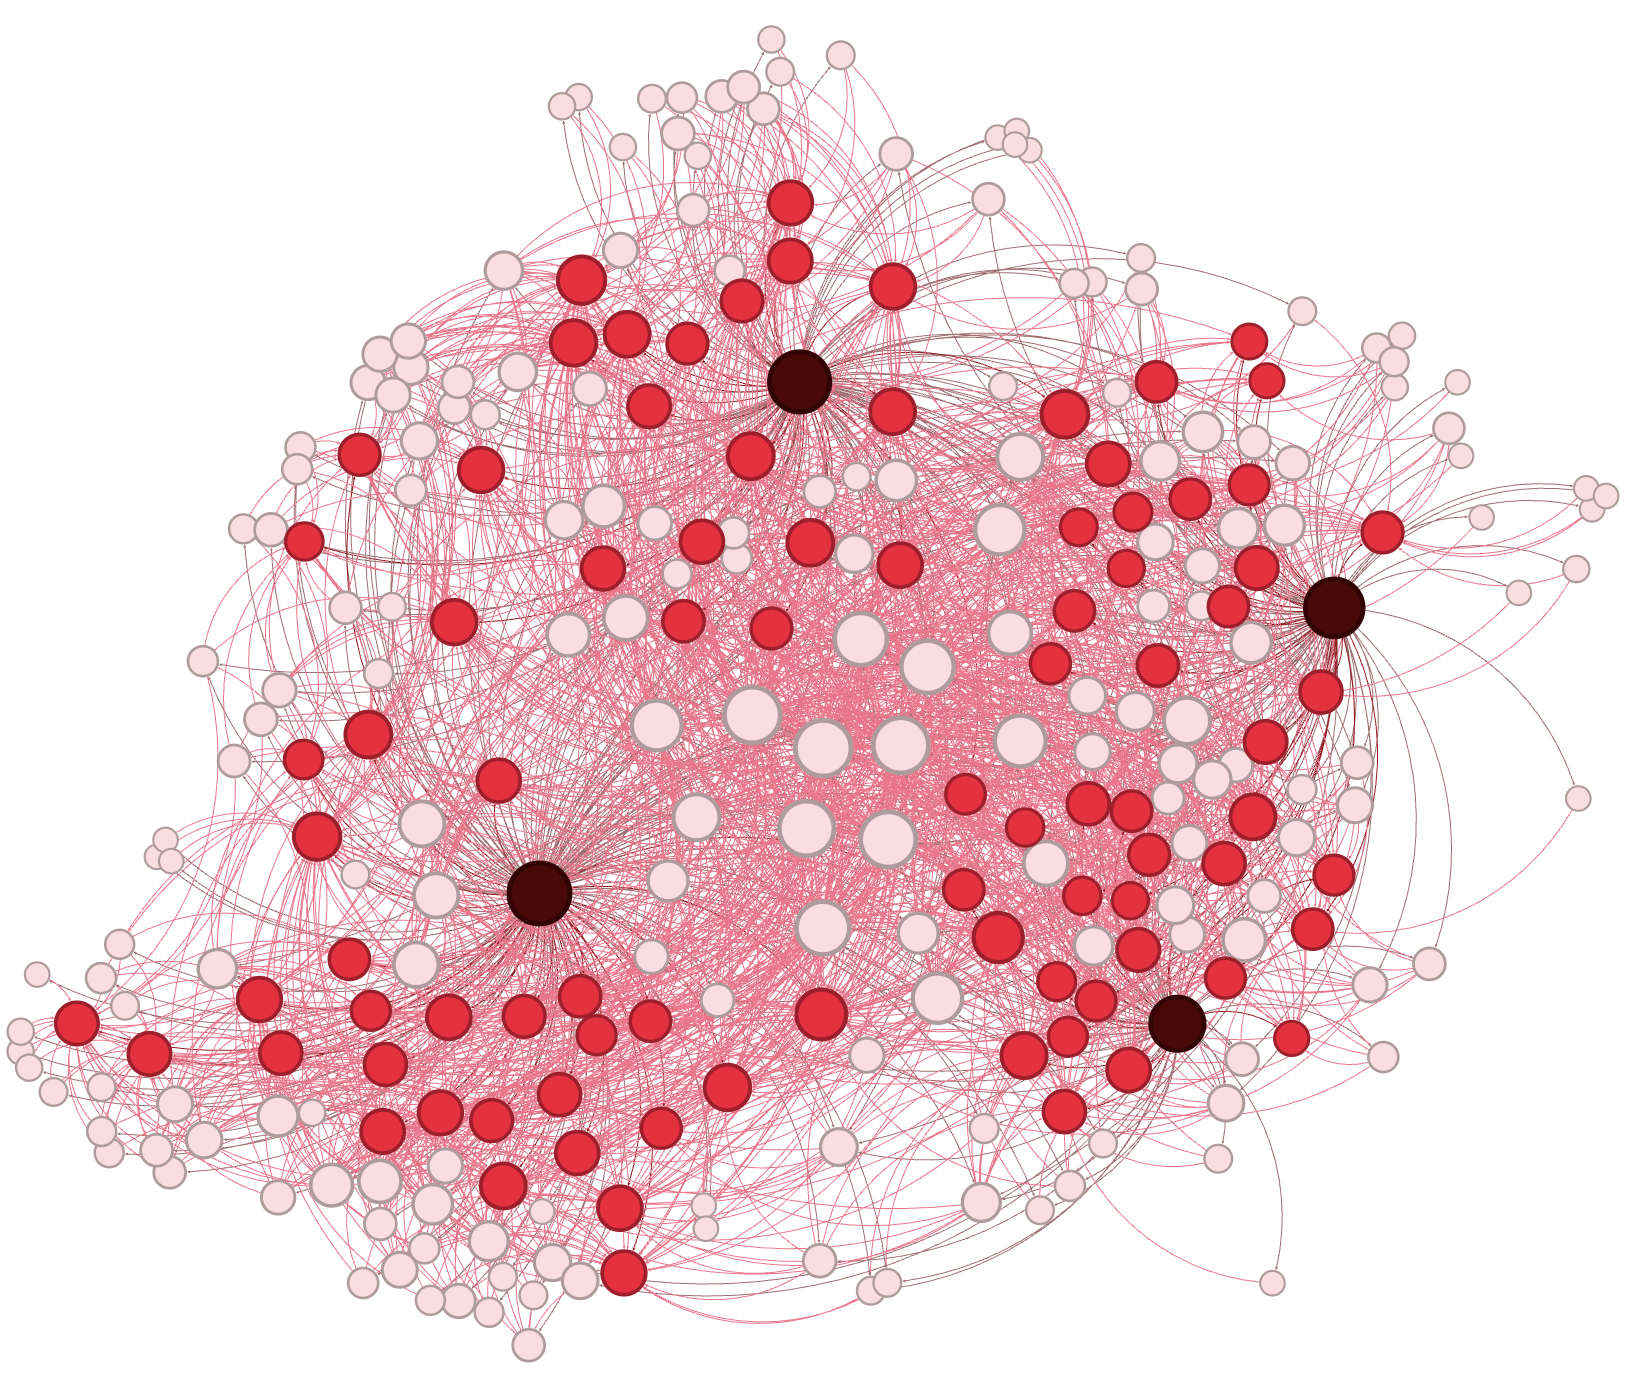

In [12]:
display(Image(filename="graph.png"))

Now in true data visualization fashion, I thought it was interesting to display a bipartite graph of each individual season, to see even further the structure of the data. This step is completely optional tho and should not be considered too much

In [16]:
def build_season_subgraph(df, season):
    G_season = nx.Graph()
    
    season_node = f"Season {season}"
    G_season.add_node(season_node, layer="season", season_number=season)
    
    # Finding all characters that appear in this season
    season_chars = df[df["seasons"].apply(lambda s_list: season in s_list)]
    
    for _, row in season_chars.iterrows():
        char_name = row["name"]
        # Add character node
        G_season.add_node(char_name, layer="character")
        # Add edge season -- character
        G_season.add_edge(season_node, char_name)
        
    # For each character, gather episodes that fall into the given season, while keeping track of unique episodes within the season
    season_episodes = set()
    for _, row in season_chars.iterrows():
        char_name = row["name"]
        for ep_url in row["episodes"]:
            ep_num = get_episode_number(ep_url)
            if determine_season(ep_num) == season:
                # Add episode node
                ep_node = f"Episode {ep_num}"
                G_season.add_node(ep_node, layer="episode", episode_number=ep_num)
                season_episodes.add(ep_node)
                
                # Add edge (character, episode)
                G_season.add_edge(char_name, ep_node)
    
    # Add edges season -- episode
    for ep_node in season_episodes:
        G_season.add_edge(season_node, ep_node)
    
    return G_season

# Build subgraphs for each season
season_graphs = {}
for s in [1, 2, 3, 4]:
    subG = build_season_subgraph(df_cleaned, s)
    season_graphs[s] = subG
    print(f"Season {s} subgraph has {subG.number_of_nodes()} nodes and {subG.number_of_edges()} edges.")


Season 1 subgraph has 106 nodes and 598 edges.
Season 2 subgraph has 73 nodes and 345 edges.
Season 3 subgraph has 140 nodes and 780 edges.
Season 4 subgraph has 168 nodes and 972 edges.


Showing the 4 subplots

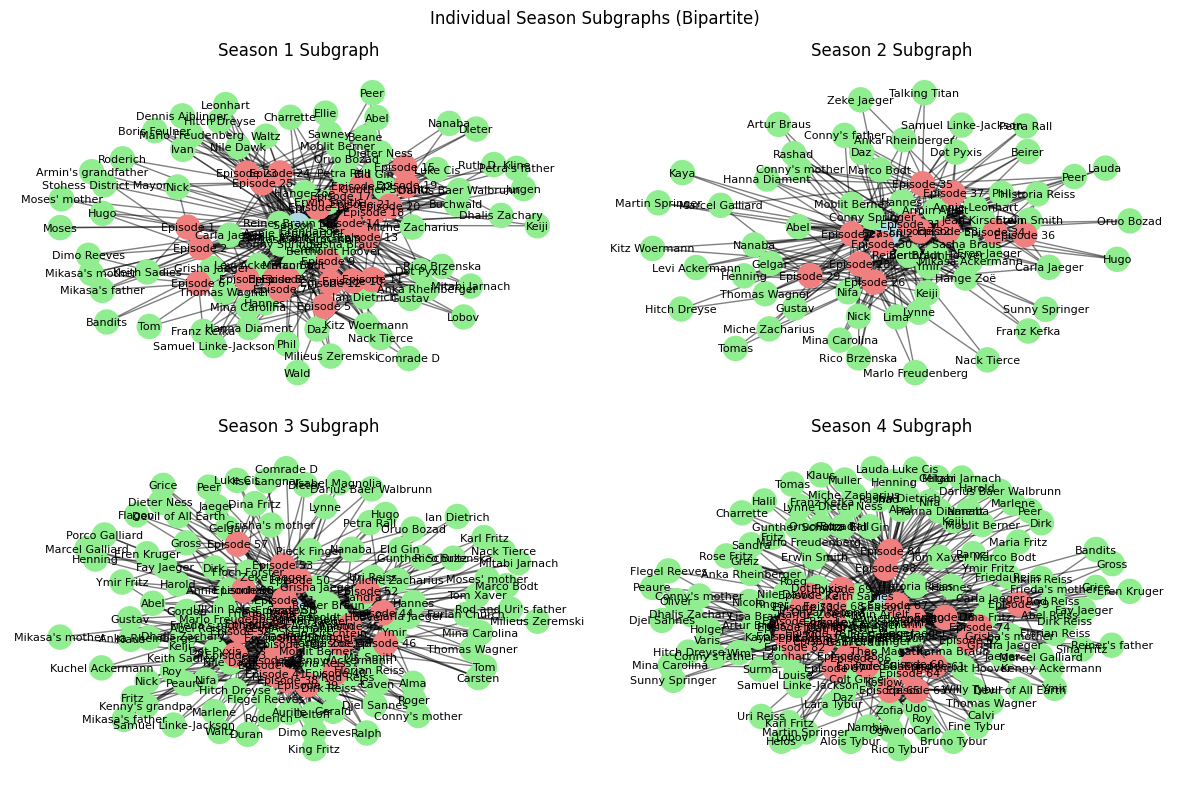

In [17]:
def get_node_color(node, graph):
    """Assign a color based on the 'layer' attribute."""
    layer = graph.nodes[node].get("layer")
    if layer == "season":
        return "lightblue"
    elif layer == "character":
        return "lightgreen"
    elif layer == "episode":
        return "lightcoral"
    else:
        return "grey"

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Individual Season Subgraphs (Bipartite)")

season_list = [1, 2, 3, 4]

for idx, s in enumerate(season_list):
    ax = axes[idx // 2, idx % 2]
    G_s = season_graphs[s]
    
    # Use a layout algorithm, e.g. spring_layout
    pos = nx.spring_layout(G_s, seed=42)  # seed for reproducibility
    
    # Draw nodes with color
    node_colors = [get_node_color(n, G_s) for n in G_s.nodes()]
    nx.draw_networkx_nodes(G_s, pos, ax=ax, node_color=node_colors)
    
    # Draw edges
    nx.draw_networkx_edges(G_s, pos, ax=ax, alpha=0.5)
    
    # Draw labels
    nx.draw_networkx_labels(G_s, pos, ax=ax, font_size=8)
    
    ax.set_title(f"Season {s} Subgraph")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Exploratory analysis

### Connected Component Analysis

In [18]:
components = list(nx.connected_components(G)) #works for undirected graphs
print(f"\nNumber of connected components: {len(components)}")

# Identifying the largest connected component (by size of the set of nodes)
largest_cc = max(components, key=len)
print(f"Size of the largest connected component: {len(largest_cc)}")

# Isolating the subgraph of the largest CC:
G_largest_cc = G.subgraph(largest_cc).copy()
print(f"Largest CC subgraph nodes: {G_largest_cc.number_of_nodes()}")
print(f"Largest CC subgraph edges: {G_largest_cc.number_of_edges()}")


Number of connected components: 10
Size of the largest connected component: 283
Largest CC subgraph nodes: 283
Largest CC subgraph edges: 2695


### Centrality measures (degree distribution etc)

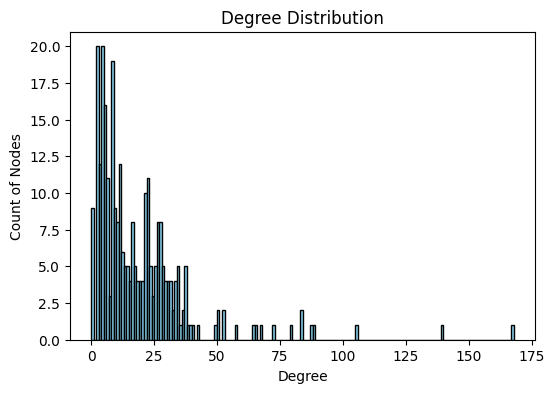

Min degree: 0
Max degree: 167
Mean degree: 18.46
Median degree: 13.00


In [21]:
# Get degrees of all nodes
degrees = [val for (node, val) in G.degree()]

# Let's do a quick histogram
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=range(min(degrees), max(degrees)+2), color="skyblue", edgecolor="black")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count of Nodes")
plt.show()

# Let's analyze some basic statistics
import statistics
print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Mean degree: {statistics.mean(degrees):.2f}")
print(f"Median degree: {statistics.median(degrees):.2f}")


Comparing Degree Distributio for the full graph vs largest connected component (LCC)

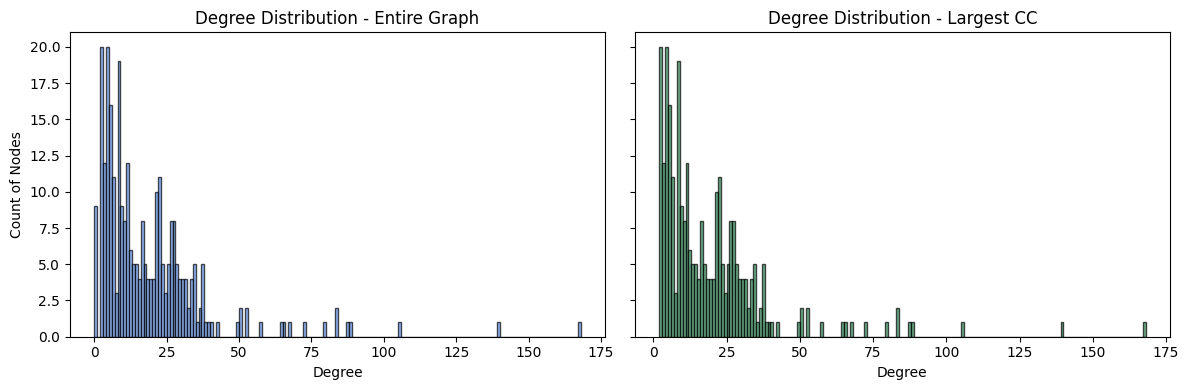

=== Entire Graph ===
  Min degree:   0
  Max degree:   167
  Mean degree:  18.46
  Median degree:13.00

=== Largest CC ===
  Min degree:   2
  Max degree:   167
  Mean degree:  19.05
  Median degree:14.00


In [24]:
# -- Descriptive statistics for the full graph --
degrees_full = [deg for _, deg in G.degree()]
min_full, max_full = min(degrees_full), max(degrees_full)
mean_full = statistics.mean(degrees_full)
median_full = statistics.median(degrees_full)

# -- Descriptive statistics for the largest connected component --
degrees_lcc = [deg for _, deg in G_largest_cc.degree()]
min_lcc, max_lcc = min(degrees_lcc), max(degrees_lcc)
mean_lcc = statistics.mean(degrees_lcc)
median_lcc = statistics.median(degrees_lcc)

# --- Side-by-side histograms ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Histogram bins:
full_bins = range(min_full, max_full + 2)
lcc_bins = range(min_lcc, max_lcc + 2)

axes[0].hist(degrees_full, bins=full_bins, color="cornflowerblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Degree Distribution - Entire Graph")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Count of Nodes")

axes[1].hist(degrees_lcc, bins=lcc_bins, color="seagreen", edgecolor="black", alpha=0.7)
axes[1].set_title("Degree Distribution - Largest CC")
axes[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

# --- Print Basic Stats ---
print("=== Entire Graph ===")
print(f"  Min degree:   {min_full}")
print(f"  Max degree:   {max_full}")
print(f"  Mean degree:  {mean_full:.2f}")
print(f"  Median degree:{median_full:.2f}")
print()
print("=== Largest CC ===")
print(f"  Min degree:   {min_lcc}")
print(f"  Max degree:   {max_lcc}")
print(f"  Mean degree:  {mean_lcc:.2f}")
print(f"  Median degree:{median_lcc:.2f}")


# Advanced Analysis


In this section, advanced network metrics are analysed.

### Centrality Analysis
Closeness and Katz centrality, betweennes and comparing characters/episodes/seasons under each measure

In [26]:
# Closeness Centrality
closeness = nx.closeness_centrality(G) # --> Dictionary

# Katz Centrality: usually requires directed graph but networkx can treat each edge as bidirectional
try:
    katz = nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0) # --> Dictionary
except nx.PowerIterationFailedConvergence:
    print("Katz centrality did not converge with alpha=0.01, please lower alpha or adjust parameters.")
    katz = None

# Sort by closeness or Katz to see top nodes
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_katz = []
if katz is not None:
    sorted_katz = sorted(katz.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Nodes by Closeness Centrality")
for node, val in sorted_closeness:
    print(f"{node:25s} -> {val:.4f}")

print("Top 10 Nodes by Katz Centrality")
for node, val in sorted_katz:
    print(f"{node:25s} -> {val:.4f}")


Top 10 Nodes by Closeness Centrality
Season 4                  -> 0.6073
Eren Jaeger               -> 0.5741
Mikasa Ackermann          -> 0.5729
Armin Arlelt              -> 0.5681
Conny Springer            -> 0.5681
Jean Kirschtein           -> 0.5635
Reiner Braun              -> 0.5499
Season 3                  -> 0.5477
Sasha Braus               -> 0.5477
Hange Zoë                 -> 0.5466
Top 10 Nodes by Katz Centrality
Season 4                  -> 0.1404
Season 3                  -> 0.1253
Season 1                  -> 0.1061
Eren Jaeger               -> 0.1013
Mikasa Ackermann          -> 0.1010
Conny Springer            -> 0.0987
Armin Arlelt              -> 0.0986
Jean Kirschtein           -> 0.0965
Season 2                  -> 0.0890
Reiner Braun              -> 0.0887


### Centrality Comparison and Observations

Previously, we computed closeness and Katz centralities, now let's add betweenness and create a single DataFrame


In [28]:
# Adding betweenes centrality for further comparison
betweenness = nx.betweenness_centrality(G)

# Creating a DataFrame to compare them
all_nodes = list(G.nodes())
df_centr = pd.DataFrame({
    "Node": all_nodes,
    "Closeness": [closeness.get(n, 0) for n in all_nodes],
    "Katz": [katz.get(n, 0) for n in all_nodes],
    "Betweenness": [betweenness.get(n, 0) for n in all_nodes]
})

# Sorting by Katz centrality (completely arbitary)
df_centr.sort_values("Katz", ascending=False, inplace=True)

df_centr.head(10)

,Node,Closeness,Katz,Betweenness
3,Season 4,0.607285,0.140400,0.262252
2,Season 3,0.547652,0.125318,0.168440
0,Season 1,0.479436,0.106057,0.113165
190,Eren Jaeger,0.574114,0.101329,0.034886
5,Mikasa Ackermann,0.572911,0.101028,0.031109
7,Conny Springer,0.568146,0.098663,0.028380
4,Armin Arlelt,0.568146,0.098626,0.026965
6,Jean Kirschtein,0.563461,0.096467,0.024283
1,Season 2,0.438649,0.088951,0.034856
89,Reiner Braun,0.549856,0.088741,0.019005


Next, we look at:
  - Edge Betweenness Centrality: to identify which edges are critical bridges.
  - Simple Motif/Subgraph Patterns (like triangles or small cycles).


In [ ]:
# Edge betweenness centrality identifies edges that appear in many shortest paths, which are likely to be critical bridges
edge_betw = nx.edge_betweenness_centrality(G)
# Show top 10 edges by betweenness
top_edge_betw = sorted(edge_betw.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Edges by Betweenness Centrality")
for (u, v), val in top_edge_betw:
    print(f"({u} -- {v}): {val:.4f}")


Top 10 Edges by Betweenness Centrality
(Season 4 -- Helos): 0.0061
(Season 4 -- Reiner's father): 0.0057
(Season 4 -- Sina Fritz): 0.0055
(Season 4 -- Rose Fritz): 0.0055
(Season 4 -- Maria Fritz): 0.0055
(Season 4 -- Alois Tybur): 0.0055
(Season 4 -- Bruno Tybur): 0.0055
(Season 4 -- Rico Tybur): 0.0055
(Season 1 -- Moses): 0.0054
(Season 1 -- Wald): 0.0052


In [32]:
triangles = nx.triangles(G)  # dict: node -> count of triangles that node participates in
# Each triangle is counted for all 3 nodes in it, so the total # of distinct triangles is:
total_triangles = sum(triangles.values()) / 3

print(f"Number of triangles in this graph: {int(total_triangles)}")

Number of triangles in this graph: 2212


It is important to consider that due to the tripartite and undirected structure of the graph the triangular pattern is expected and does not constitute a particularly notable point.


### SIR Model

Next, an attempt was made at implementing a SIR model (Susceptible - Infected - Recover). This is a compartmental model and is often used in epidemiology. However, in my understanding of it, it can be implemented in analysing an anime character network because of some feature such as:
1. **Temporary state**: Characters (or nodes) that 'recover' from certain information or event (e.g., they are no longer actively disseminating it).
2. **Realistic simulation**: In an anime context, a rumor/event may eventually die out for a given character (they 'recover'), making SIR more appropriate than an SI model (where once infected, a node remains infected forever).
3. **Analogy to storyline arcs**: Characters can be heavily involved in a plot (infected), then move on (recover) while other characters remain unaffected, until bridging episodes bring them back in. This mimics how storylines appear and resolve.

The process will require building a function that carries out a basic SIR simulation on an undirected graph, for which we will need:
    - p_infect: Probability an infected node infects a susceptible neighbor per step.
    - p_recover: Probability an infected node recovers at each step.
    - initial_infected_fraction: fraction of nodes to set as infected at t=0.
    - max_steps: max number of iterations to simulate.

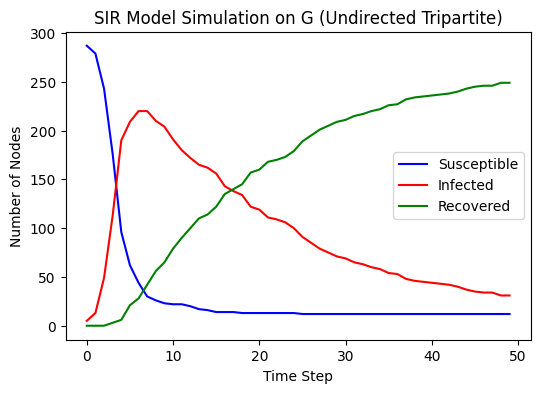

Final counts after simulation:
  Susceptible: 12
  Infected:    31
  Recovered:   249


In [35]:
def sir_simulation(G, p_infect=0.1, p_recover=0.05, initial_infected_fraction=0.01, max_steps=50):

    # States: "S", "I", "R"
    nodes = list(G.nodes())
    N = len(nodes)
    
    # Initialize states
    state = {}
    for n in nodes:
        state[n] = "S"
    
    # Infect some fraction of nodes
    infected_count = int(initial_infected_fraction * N)
    initial_infected = random.sample(nodes, infected_count)
    for n in initial_infected:
        state[n] = "I"
    
    S_list = []
    I_list = []
    R_list = []

    for step in range(max_steps):
        # Count states
        S_count = sum(1 for n in nodes if state[n] == "S")
        I_count = sum(1 for n in nodes if state[n] == "I")
        R_count = sum(1 for n in nodes if state[n] == "R")
        
        S_list.append(S_count)
        I_list.append(I_count)
        R_list.append(R_count)
        
        if I_count == 0:
            # no more infected => epidemic ends
            break
        
        # Prepare to update states
        new_state = state.copy()
        
        # Infect neighbors
        for n in nodes:
            if state[n] == "I":
                # Attempt to infect neighbors
                for neighbor in G.neighbors(n):
                    if state[neighbor] == "S":
                        if random.random() < p_infect:
                            new_state[neighbor] = "I"
        
        # Recover
        for n in nodes:
            if state[n] == "I":
                if random.random() < p_recover:
                    new_state[n] = "R"
        
        state = new_state
    
    return S_list, I_list, R_list

# Let's run a quick example. 
# NOTE: Each run will differ due to random sampling, so you can set a random seed for reproducibility.
S_list, I_list, R_list = sir_simulation(G, p_infect=0.1, p_recover=0.05, initial_infected_fraction=0.02, max_steps=50)

plt.figure(figsize=(6,4))
plt.plot(S_list, label="Susceptible", color="blue")
plt.plot(I_list, label="Infected", color="red")
plt.plot(R_list, label="Recovered", color="green")
plt.xlabel("Time Step")
plt.ylabel("Number of Nodes")
plt.title("SIR Model Simulation on G (Undirected Tripartite)")
plt.legend()
plt.show()

print("Final counts after simulation:")
print(f"  Susceptible: {S_list[-1]}")
print(f"  Infected:    {I_list[-1]}")
print(f"  Recovered:   {R_list[-1]}")


### Power Law and Degree Distribution


Calculating best minimal value for power law fit
Power-law fit results:
  alpha=3.211, xmin=21.0

Comparing Power Law vs. Exponential:
  R=1.803, p=0.071
  (R>0 => PL better fit, R<0 => EXP better fit)


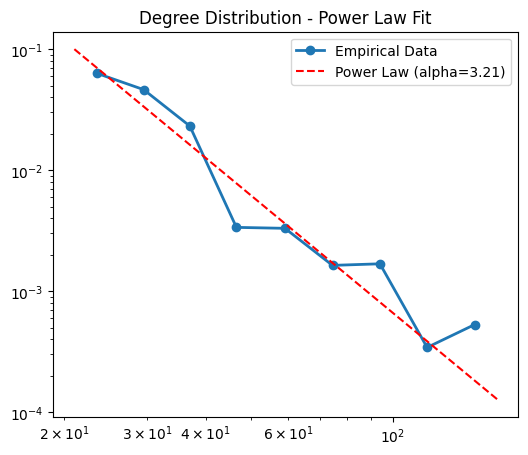

In [43]:
degrees = [deg for _, deg in G.degree() if deg > 0]  # exclude isolated if any

# Fit a power law using powerlaw
fit = powerlaw.Fit(degrees, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

print(f"Power-law fit results:\n  alpha={alpha:.3f}, xmin={xmin}")

# Compare power law with other distributions, e.g. exponential, lognormal
R_exp, p_exp = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

print("\nComparing Power Law vs. Exponential:")
print(f"  R={R_exp:.3f}, p={p_exp:.3f}")
print("  (R>0 => PL better fit, R<0 => EXP better fit)")


# Quick visual
plt.figure(figsize=(6,5))
fit.plot_pdf(label='Empirical Data', linewidth=2, marker='o')
fit.power_law.plot_pdf(label=f'Power Law (alpha={fit.alpha:.2f})', color='r', linestyle='--')
plt.legend()
plt.title("Degree Distribution - Power Law Fit")
plt.show()



Interpretation:
- alpha between ~2 and 3 often indicates a heavy-tailed, scale-free-like distribution.
- If R > 0 and p < 0.05 in distribution_compare, it suggests the first distribution 
  is significantly a better fit than the second. 
- If results are mixed (or p is large), there's no conclusive difference.

Since both of our parameters are close but not within the treshold, there is no strong suggestion of scale free property being found within this network


### Community detection

Community detection algorithms used: Infomap and Louvain

In [44]:
def print_partition_summary(partition):
    print(f"Method: {partition.method_name}")
    print(f"Number of communities: {len(partition.communities)}")
    
    sizes = [len(c) for c in partition.communities]
    print(f"Community sizes: {sizes}")
    print()

# --- Infomap ---
infomap_comm = algorithms.infomap(G)  # Infomap on an undirected graph
print("=== Infomap ===")
print_partition_summary(infomap_comm)

# --- Louvain ---
louvain_comm = algorithms.louvain(G)
print("=== Louvain ===")
print_partition_summary(louvain_comm)


=== Infomap ===
Method: Infomap
Number of communities: 10
Community sizes: [283, 1, 1, 1, 1, 1, 1, 1, 1, 1]

=== Louvain ===
Method: Louvain
Number of communities: 13
Community sizes: [82, 77, 66, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1]



### Simple role assignment

In [45]:
import pandas as pd

def assign_communities_to_nodes(G, communities):
    node2comm = {}
    for i, c_group in enumerate(communities):
        for node in c_group:
            node2comm[node] = i
    return node2comm

# Using Louvain partition as an example
node2comm = assign_communities_to_nodes(G, louvain_comm.communities)

# Computing "in-community degree" and "out-of-community degree" for each node
in_deg = {}
out_deg = {}
for node in G.nodes():
    in_deg[node] = 0
    out_deg[node] = 0

    node_comm = node2comm[node]
    neighbors = G.neighbors(node)
    for nbr in neighbors:
        if node2comm[nbr] == node_comm:
            in_deg[node] += 1
        else:
            out_deg[node] += 1


in_deg_values = list(in_deg.values())
out_deg_values = list(out_deg.values())

# Let's define arbitrary thresholds:
threshold_in = np.percentile(in_deg_values, 90)   # top 10%
threshold_out = np.percentile(out_deg_values, 90) # top 10%

roles = {}
for node in G.nodes():
    if in_deg[node] >= threshold_in:
        roles[node] = "Hub"
    elif out_deg[node] >= threshold_out:
        roles[node] = "Connector"
    else:
        roles[node] = "Periphery"

# Create a small DataFrame to inspect
role_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Community': [node2comm[n] for n in G.nodes()],
    'In_Comm_Deg': [in_deg[n] for n in G.nodes()],
    'Out_Comm_Deg': [out_deg[n] for n in G.nodes()],
    'Role': [roles[n] for n in G.nodes()]
})
role_df.sort_values("Role", inplace=True)  # Just to group roles
role_df.head(20)


,Node,Community,In_Comm_Deg,Out_Comm_Deg,Role
291,Episode 88,3,15,37,Connector
228,Episode 25,3,12,17,Connector
241,Episode 38,0,16,17,Connector
25,Moblit Berner,3,10,27,Connector
247,Episode 44,0,18,19,Connector
252,Episode 49,0,15,22,Connector
254,Episode 51,2,13,18,Connector
256,Episode 53,3,17,23,Connector
15,Erwin Smith,3,14,36,Connector
11,Hange Zoë,3,13,51,Connector


In [46]:
# Create sets of character names that appear in each season
s1_chars = set(df_cleaned[df_cleaned['seasons'].apply(lambda seasons: 1 in seasons)]['name'])
s2_chars = set(df_cleaned[df_cleaned['seasons'].apply(lambda seasons: 2 in seasons)]['name'])
s3_chars = set(df_cleaned[df_cleaned['seasons'].apply(lambda seasons: 3 in seasons)]['name'])
s4_chars = set(df_cleaned[df_cleaned['seasons'].apply(lambda seasons: 4 in seasons)]['name'])

def jaccard_index(a, b):
    intersect = len(a & b)
    union = len(a | b)
    return intersect / union if union != 0 else 0

# Compute Jaccard indices
j_12 = jaccard_index(s1_chars, s2_chars)
j_23 = jaccard_index(s2_chars, s3_chars)
j_34 = jaccard_index(s3_chars, s4_chars)

print("Jaccard Index (Season 1 & 2):", j_12)
print("Jaccard Index (Season 2 & 3):", j_23)
print("Jaccard Index (Season 3 & 4):", j_34)

Jaccard Index (Season 1 & 2): 0.41414141414141414
Jaccard Index (Season 2 & 3): 0.3308270676691729
Jaccard Index (Season 3 & 4): 0.48255813953488375


In the context here, the Jaccard Index was used to compare the sets of characters appearing in different seasons. A higher Jaccard Index between two seasons implies many of the same characters are present in both seasons, whereas a lower value suggests that the two seasons share fewer common characters.

### Advanced link prediction

Node2Vec

In [48]:
node2vec = Node2Vec(G, dimensions=16, walk_length=10, num_walks=100, workers=1, seed=42)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Prepare "positive edges" (existing edges in G) and sample "negative edges" (pairs of nodes not connected) for training.
edges = list(G.edges())
X_pos = []
for (u, v) in edges:
    emb_u = model.wv.get_vector(u)
    emb_v = model.wv.get_vector(v) # simple approach: combine by elementwise multiplication or concat
    X_pos.append(emb_u * emb_v)

# Sample negative edges, naive approach: pick random pairs that are not edges
all_nodes = list(G.nodes())
non_edges = []
while len(non_edges) < len(edges):
    a, b = np.random.choice(all_nodes, 2, replace=False)
    if not G.has_edge(a, b):
        non_edges.append((a,b))

X_neg = []
for (u, v) in non_edges:
    emb_u = model.wv.get_vector(u)
    emb_v = model.wv.get_vector(v)
    X_neg.append(emb_u * emb_v)

# Labels: 1 for positive edges, 0 for negative
y_pos = [1]*len(X_pos)
y_neg = [0]*len(X_neg)

X = np.vstack((X_pos, X_neg))
y = np.hstack((y_pos, y_neg))

# Train/test split + random forest example
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

acc = clf.score(X_test, y_test)
print(f"Link Prediction Accuracy: {acc:.3f}")





Computing transition probabilities:   0%|          | 0/292 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 112.89it/s]


Link Prediction Accuracy: 0.852


The model can be used to predict future links that are not present in G.

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict labels on the test set
y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# Compute ROC-AUC (requires predict_proba)
y_proba = clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc_score:.3f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       784
           1       0.87      0.84      0.85       833

    accuracy                           0.85      1617
   macro avg       0.85      0.85      0.85      1617
weighted avg       0.85      0.85      0.85      1617

=== Confusion Matrix ===
[[681 103]
 [136 697]]
ROC-AUC: 0.931


In [52]:
# 1. Identify all candidate non-edges (pairs of nodes not in G)
candidate_non_edges = []
all_nodes = list(G.nodes())
for i in range(len(all_nodes)):
    for j in range(i+1, len(all_nodes)):
        u = all_nodes[i]
        v = all_nodes[j]
        if not G.has_edge(u, v):
            candidate_non_edges.append((u, v))

# 2. Predict probabilities for each candidate
predictions = []
for (u, v) in candidate_non_edges:
    emb_u = model.wv.get_vector(u)
    emb_v = model.wv.get_vector(v)
    # Combine embeddings. Same approach as training (elementwise multiply here).
    X_sample = emb_u * emb_v
    proba = clf.predict_proba([X_sample])[0, 1]  # Probability of "1" (edge exists)
    predictions.append(((u, v), proba))

# 3. Sort by probability descending
predictions.sort(key=lambda x: x[1], reverse=True)

# 4. Show top 10 most likely new edges
top_10 = predictions[:10]
print("=== Top 10 Potential New Edges (not in G) ===")
for edge, score in top_10:
    print(f"{edge} -> Probability={score:.4f}")


=== Top 10 Potential New Edges (not in G) ===
('Klaus', 'Episode 50') -> Probability=0.9900
('Erwin Smith', 'Episode 28') -> Probability=0.9800
('Hange Zoë', 'Episode 36') -> Probability=0.9700
('Nile Dawk', 'Episode 12') -> Probability=0.9700
('Ulklin Reiss', 'Grisha Jaeger') -> Probability=0.9700
('Conny Springer', 'Episode 21') -> Probability=0.9600
('Levi Ackermann', 'Florian Reiss') -> Probability=0.9600
('Nanaba', 'Nick') -> Probability=0.9600
('Darius Baer Walbrunn', 'Dieter Ness') -> Probability=0.9600
('Dot Pyxis', 'Dhalis Zachary') -> Probability=0.9600


This can be explained at times by the fast pace of the anime. **Spoilers ahead** For example, the character named Klaus dies in Episode 49 after a series of episode showed him and the other scout regimen soldier fight closely. Since he dies and his comrades do not, it is expected that the link prediction model would see him in the next episode as well, well all other soldiers are displayed. Unfortunately for Klaus, this is not the case.

# Project Summary

This project analyzed *Attack on Titan* character interactions using network science. Key findings include:

- **Graph Analysis**: The tripartite graph revealed a highly interconnected network, with central figures like Eren Jaeger and Mikasa Ackermann.
- **Community Detection**: Clusters reflected major story arcs and affiliations.
- **Dynamic Modeling**: Simulations captured the spread of narrative elements across characters.
- **Link Prediction**: Models suggested realistic future connections within the story.

### Next Steps

Future work will focus on incorporating temporal dynamics, refining predictive models, and comparing results with other narrative networks.